<a href="https://colab.research.google.com/github/SecondThread/MachineLearningClass/blob/master/HW4/pretrained_convnet_finetuning_with_ResNet50V2%2C_different_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning ResNet50V2

This is based on section 5.3 *Using a pretrained convnet* of the book *Deep learning with Python* by Francois Chollet and on the pretrained_convnent_finetuning document made for this class. I have made several changes to that code.

I use ResNet50V2 in this section. Unlike the prvious version, here I chose to add a second layer for my classifier of fewer nodes, and I also added dropout. Unfortunately, neither of these steps were too helpful, and again it looks like I made my model worse after unlocking the 5th convolutional layer for fine-tuning. Anyway, I was able to get a final accuracy of ~95.3% (and an intermediate accuracty of ~97% before unlocking the 5th convolutional layer).

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-21 04:45:56--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.14.112, 2607:f8b0:4007:808::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.14.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   194MB/s    in 0.3s    

2020-04-21 04:45:57 (194 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with ResNet50V2 convolution base and custom densely connected layers

### Load the convolutional base

In [0]:
from keras.applications.resnet_v2 import ResNet50V2

conv_base = ResNet50V2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Using TensorFlow backend.


94674944/94668760 [==============================] - 2s 0us/step


### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

## Train the model end to end with frozen convolutional base

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 29s 290ms/step - loss: 0.4973 - acc: 0.7480 - val_loss: 0.0833 - val_acc: 0.9330
Epoch 2/30
100/100 [==============================] - 19s 191ms/step - loss: 0.4061 - acc: 0.8150 - val_loss: 0.0017 - val_acc: 0.9530
Epoch 3/30
100/100 [==============================] - 19s 189ms/step - loss: 0.3624 - acc: 0.8355 - val_loss: 0.0083 - val_acc: 0.9510
Epoch 4/30
100/100 [==============================] - 19s 187ms/step - loss: 0.3378 - acc: 0.8510 - val_loss: 0.3473 - val_acc: 0.9550
Epoch 5/30
100/100 [==============================] - 19s 192ms/step - loss: 0.3525 - acc: 0.8485 - val_loss: 0.1199 - val_acc: 0.9540
Epoch 6/30
100/100 [==============================] - 19s 189ms/step - loss: 0.3147 - acc: 0.8615 - val_loss: 7.3754e-04 - val_acc: 0.9570
Epoch 7/30
100/100 [==============================] - 19s 189ms/step - loss: 0.2996 - acc: 0.8670 - va

## Display curves of loss and accuracy during training

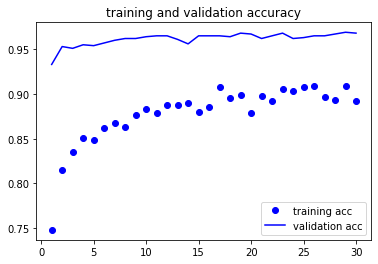

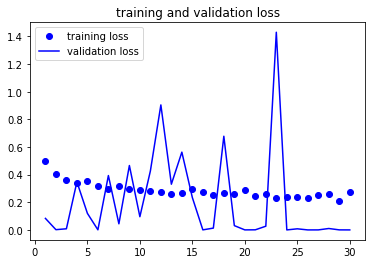

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  print(layer.name);
  set_trainable |= layer.name == 'conv5_block1_preact_bn';
  layer.trainable = set_trainable;
  print(set_trainable);
  # if layer.name == 'block5_conv1':
  #   set_trainable = True
  # if set_trainable:
  #   layer.trainable = True
  # else:
  #   layer.trainable = False

input_1
False
conv1_pad
False
conv1_conv
False
pool1_pad
False
pool1_pool
False
conv2_block1_preact_bn
False
conv2_block1_preact_relu
False
conv2_block1_1_conv
False
conv2_block1_1_bn
False
conv2_block1_1_relu
False
conv2_block1_2_pad
False
conv2_block1_2_conv
False
conv2_block1_2_bn
False
conv2_block1_2_relu
False
conv2_block1_0_conv
False
conv2_block1_3_conv
False
conv2_block1_out
False
conv2_block2_preact_bn
False
conv2_block2_preact_relu
False
conv2_block2_1_conv
False
conv2_block2_1_bn
False
conv2_block2_1_relu
False
conv2_block2_2_pad
False
conv2_block2_2_conv
False
conv2_block2_2_bn
False
conv2_block2_2_relu
False
conv2_block2_3_conv
False
conv2_block2_out
False
conv2_block3_preact_bn
False
conv2_block3_preact_relu
False
conv2_block3_1_conv
False
conv2_block3_1_bn
False
conv2_block3_1_relu
False
conv2_block3_2_pad
False
conv2_block3_2_conv
False
conv2_block3_2_bn
False
conv2_block3_2_relu
False
max_pooling2d_1
False
conv2_block3_3_conv
False
conv2_block3_out
False
conv3_block1_p

In [0]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 27s 269ms/step - loss: 0.2556 - acc: 0.8965 - val_loss: 0.0066 - val_acc: 0.9400
Epoch 2/100
100/100 [==============================] - 21s 209ms/step - loss: 0.2360 - acc: 0.9075 - val_loss: 0.1543 - val_acc: 0.9260
Epoch 3/100
100/100 [==============================] - 21s 211ms/step - loss: 0.2005 - acc: 0.9265 - val_loss: 0.3041 - val_acc: 0.9320
Epoch 4/100
100/100 [==============================] - 21s 211ms/step - loss: 0.2175 - acc: 0.9220 - val_loss: 0.1450 - val_acc: 0.9390
Epoch 5/100
100/100 [==============================] - 21s 211ms/step - loss: 0.2012 - acc: 0.9280 - val_loss: 0.0209 - val_acc: 0.9400
Epoch 6/100
100/100 [==============================] - 21s 209ms/step - loss: 0.2039 - acc: 0.9270 - val_loss: 0.9110 - val_acc: 0.9430
Epoch 7/100
100/100 [==============================] - 21s 210ms/step - loss: 0.1671 - acc: 0.9390 - val_loss: 0.1228 - val_acc: 0.9420
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

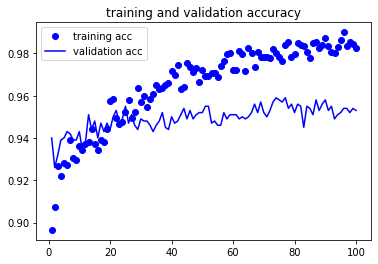

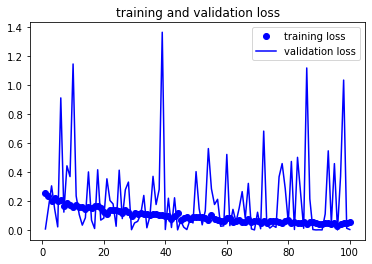

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

This looks like overfitting. I should try  adding dropout for the densely connected layer.

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [0]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.08171457052230835
Validation accuracy: 0.953000009059906


## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_7.h7' 
model.save(model_fname)

In [0]:
from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)